# GIS Data Science Assignment: Climate Change Analysis in Tanzania

In this assignment, you will analyze climate change patterns in Tanzania using GIS data. You will work with spatial data to understand, visualize, and analyze climate trends across different regions of Tanzania.

## Setup
First, let's import the necessary libraries:

In [119]:
# Run this cell to install any missing dependencies
# !pip install geopandas matplotlib numpy pandas seaborn folium mapclassify xarray rasterio contextily

In [157]:
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os
from matplotlib.colors import ListedColormap
import contextily as ctx
from scipy import stats
import shapely

gpd.box = shapely.geometry.box

# Set plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style="whitegrid")

## Part 1: GIS Data Basics

### Task 1.1: Load the Tanzania Shapefile
Load the Tanzania administrative boundaries shapefile and examine its structure.

In [122]:
# TODO: Load the Tanzania shapefile
# Hint: Use gpd.read_file() to load the shapefile
tz_shapefile = gpd.read_file('data/tanzania_regions.shp')

# Function to display basic information about a GeoDataFrame
def describe_geodataframe(gdf):
    """Display basic information about a GeoDataFrame.
    
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame to describe
    
    Returns:
    dict: A dictionary containing basic information about the GeoDataFrame
    """
    info = {
        'crs': gdf.crs,
        'geometry_type': gdf.geometry.geom_type.iloc[0] if not gdf.empty else None,
        'num_features': len(gdf),
        'attributes': list(gdf.columns),
        'total_area': gdf.to_crs(epsg=3395).area.sum() / 10**6 if not gdf.empty else 0,  # Area in sq km
        'bounds': gdf.total_bounds.tolist() if not gdf.empty else []
    }
    return info

# Call the function with your loaded shapefile
tz_info = describe_geodataframe(tz_shapefile)

### Task 1.2: Understand Coordinate Reference Systems
Explain the current CRS and reproject the data to a suitable projection for Tanzania.

In [124]:
# TODO: Identify the current CRS and explain why it might not be optimal for Tanzania

# TODO: Reproject the data to a more appropriate CRS for Tanzania
# Hint: Consider using EPSG:21037 (Arc 1960 / UTM zone 37S) which is suitable for Tanzania
print(f"Current CRS: {tz_shapefile.crs}")
print("This is likely a geographic coordinate system (lat/long), uses degrees, causing distortion and inaccuracies for distance and area calculations in Tanzania")

# Reproject to a more appropriate CRS for Tanzania (UTM Zone 37S - EPSG:21037)
tz_projected = tz_shapefile.to_crs(epsg=21037)

# TODO: Compare the original and reprojected data
# Hint: Create a function that compares areas before and after reprojection
def compare_projections(original_gdf, reprojected_gdf):
    """Compare the original and reprojected GeoDataFrames.
    
    Parameters:
    original_gdf (GeoDataFrame): The original GeoDataFrame
    reprojected_gdf (GeoDataFrame): The reprojected GeoDataFrame
    
    Returns:
    dict: A dictionary containing comparison metrics
    """

    #Calculate areas in square Kilometers
    orig_area = original_gdf.to_crs(epsg=3395).area.sum()/10**6
    new_area = reprojected_gdf.area.sum()/10**6
    
    comparison = {
        'original_crs': original_gdf.to_crs,
        'new_crs': reprojected_gdf.to_crs,
        'original_area': orig_area,
        'new_area': new_area,
        'percent_difference': ((new_area - orig_area) / orig_area) * 100 if orig_area != 0 else 0
    }
    return comparison

# Call the comparison function
projection_comparison = compare_projections(tz_shapefile, tz_projected)


Current CRS: EPSG:4326
This is likely a geographic coordinate system (lat/long), uses degrees, causing distortion and inaccuracies for distance and area calculations in Tanzania


## Part 2: Data Loading and Processing

### Task 2.1: Load Climate Data
Load the provided climate data for Tanzania and examine its structure.

In [126]:
# TODO: Load the climate data CSV file
climate_data = pd.read_csv('data/tanzania_annual_climate_data.csv')

# TODO: Display the first few rows and basic statistics of the climate data
# Hint: Use .head(), .describe(), and .info() methods

print("Climate Data Information:")
print(f"- Shape: {climate_data.shape}")
print(f"- Columns: {climate_data.columns.tolist()}")
print("\nFirst few rows:")
print(climate_data.head())

# TODO: Check for missing values and handle them appropriately
def check_missing_values(df):
    """Check for missing values in a DataFrame and return a summary.
    
    Parameters:
    df (DataFrame): The DataFrame to check
    
    Returns:
    DataFrame: A summary of missing values by column
    """
    missing_values = pd.DataFrame({
        'count': df.isna().sum(),
        'percent': (df.isna().sum() / len(df)) * 100
    })
    return missing_values[missing_values['count'] > 0]

missing_summary = check_missing_values(climate_data)


Climate Data Information:
- Shape: (744, 13)
- Columns: ['REGION_CODE', 'REGION_NAME', 'YEAR', 'ZONE', 'ANNUAL_AVG_TEMP_C', 'MAX_TEMP_C', 'MIN_TEMP_C', 'ANNUAL_PRECIP_MM', 'ANNUAL_RAIN_DAYS', 'ANNUAL_HEAVY_RAIN_DAYS', 'ANNUAL_DROUGHT_INDEX', 'ELEVATION_M', 'DISTANCE_TO_COAST_KM']

First few rows:


,REGION_CODE,REGION_NAME,YEAR,ZONE,ANNUAL_AVG_TEMP_C,MAX_TEMP_C,MIN_TEMP_C,ANNUAL_PRECIP_MM,ANNUAL_RAIN_DAYS,ANNUAL_HEAVY_RAIN_DAYS,ANNUAL_DROUGHT_INDEX,ELEVATION_M,DISTANCE_TO_COAST_KM
0,AR,Arusha,2000,Northern,21.71,26.60,16.99,6918.2,107,21,0.105833,920.2,469.3
1,AR,Arusha,2001,Northern,22.45,27.81,17.78,6333.0,104,15,0.428333,920.2,469.3
2,AR,Arusha,2002,Northern,22.81,27.30,17.74,10795.2,144,41,0.000000,920.2,469.3
3,AR,Arusha,2003,Northern,21.38,25.77,16.39,5592.0,62,10,0.899167,920.2,469.3
4,AR,Arusha,2004,Northern,21.67,26.89,16.57,10407.2,150,39,0.000000,920.2,469.3


### Task 2.2: Join Climate Data with Spatial Data
Merge the climate data with the Tanzania shapefile based on a common identifier.

In [128]:
# TODO: Identify the common field between the climate data and the shapefile
# Hint: Look for a region/district identifier in both datasets

print("Tanzania shapefile columns:", tz_projected.columns.tolist())
print("Climate data columns:", climate_data.columns.tolist())

# TODO: Join the climate data with the shapefile
# Hint: Use the merge() or join() method

# Merge the climate data with the shapefile using REGION_CODE and REGION_COD
tz_climate = tz_projected.merge(climate_data, left_on="REGION_COD", right_on="REGION_CODE", how="left")


# TODO: Verify the join was successful by checking the shape and contents of the result
def verify_join(original_gdf, joined_gdf, climate_df):
    """Verify that the join between spatial and climate data was successful.
    
    Parameters:
    original_gdf (GeoDataFrame): The original spatial GeoDataFrame
    joined_gdf (GeoDataFrame): The joined GeoDataFrame
    climate_df (DataFrame): The climate DataFrame
    
    Returns:
    dict: A dictionary containing verification metrics
    """
    # Calculate climate columns that should appear in joined dataframe
    climate_cols = set(climate_df.columns)
    original_cols = set(original_gdf.columns)
    expected_new_cols = climate_cols - original_cols
    actual_new_cols = set(joined_gdf.columns) - original_cols
    
    verification = {
        'original_features': len(original_gdf),
        'joined_features': len(joined_gdf),
        'climate_records': len(climate_df),
        'joined_columns': list(joined_gdf.columns),
        'is_successful': len(joined_gdf) > 0 and len(actual_new_cols) > 0,
        'expected_new_columns': len(expected_new_cols),
        'actual_new_columns': len(actual_new_cols)
    }
    return verification

join_verification = verify_join(tz_projected, tz_climate, climate_data)

Tanzania shapefile columns: ['REGION_NAM', 'REGION_COD', 'ZONE', 'LAND_AREA_', 'POPULATION', 'POP_DENSIT', 'ELEVATION_', 'DIST_TO_CO', 'geometry']
Climate data columns: ['REGION_CODE', 'REGION_NAME', 'YEAR', 'ZONE', 'ANNUAL_AVG_TEMP_C', 'MAX_TEMP_C', 'MIN_TEMP_C', 'ANNUAL_PRECIP_MM', 'ANNUAL_RAIN_DAYS', 'ANNUAL_HEAVY_RAIN_DAYS', 'ANNUAL_DROUGHT_INDEX', 'ELEVATION_M', 'DISTANCE_TO_COAST_KM']


## Part 3: Data Visualization

### Task 3.1: Create a Choropleth Map
Create a choropleth map showing average temperature across Tanzania regions.

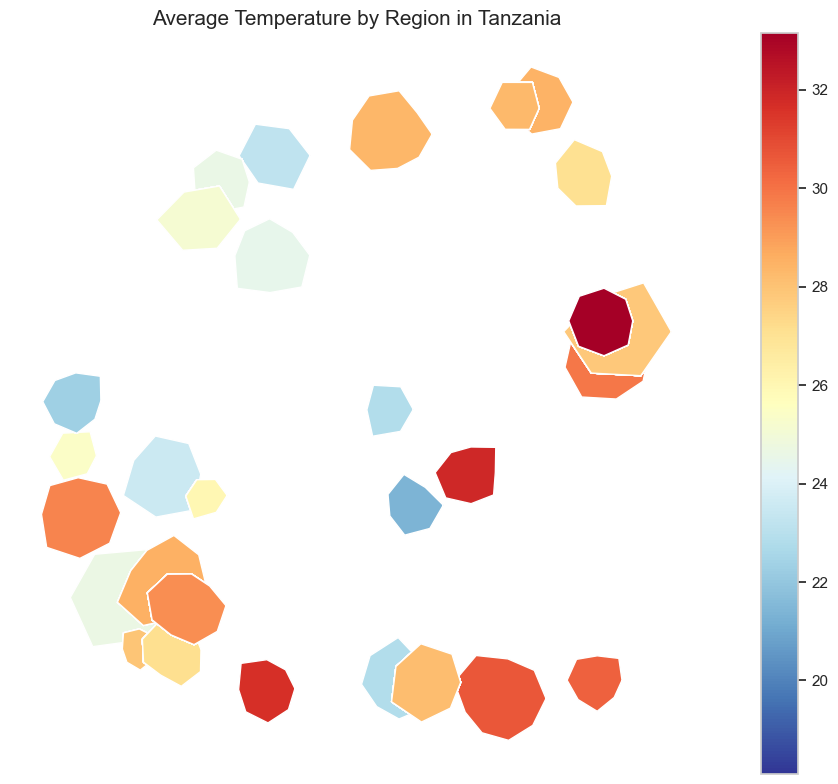

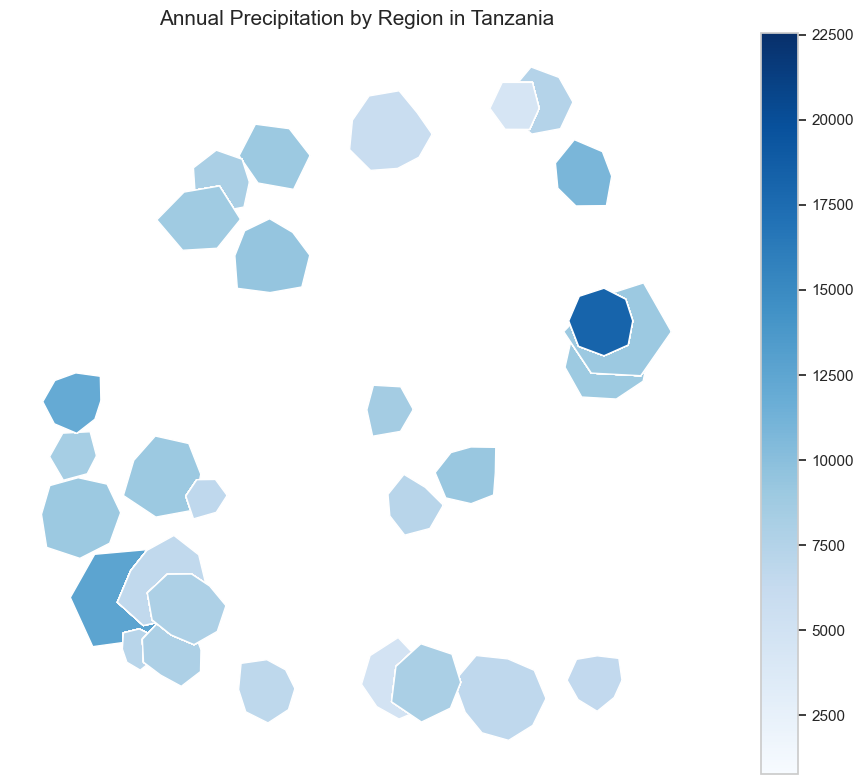

In [130]:
# TODO: Create a choropleth map of average temperature by region
# Hint: Use the .plot() method with the column parameter
def create_choropleth(gdf, column, title, cmap='viridis', figsize=(12, 8)):
    """Create a choropleth map for a GeoDataFrame.
    
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame to plot
    column (str): The column to use for coloring
    title (str): The title of the map
    cmap (str or Colormap): The colormap to use
    figsize (tuple): The figure size
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the choropleth
    gdf.plot(column=column, cmap=cmap, legend=True, ax=ax)
    
    # Add basemap if CRS is compatible
    if gdf.crs and (gdf.crs.to_string() == 'EPSG:4326' or gdf.crs.to_string() == 'EPSG:3857'):
        try:
            ctx.add_basemap(ax, crs=gdf.crs.to_string())
        except Exception as e:
            print(f"Could not add basemap: {e}")
    
    # Add title and improve layout
    ax.set_title(title, fontsize=15)
    ax.set_axis_off()
    
    plt.tight_layout()
    return fig

# Create choropleth maps for temperature and precipitation
# Use appropriate column names from your data
temp_col = 'ANNUAL_AVG_TEMP_C'  
precip_col = 'ANNUAL_PRECIP_MM'  

# Check if columns exist before creating choropleth
temp_exists = temp_col in tz_climate.columns if len(tz_climate) > 0 else False
precip_exists = precip_col in tz_climate.columns if len(tz_climate) > 0 else False

if temp_exists:
    temp_map = create_choropleth(
        tz_climate, 
        temp_col, 
        'Average Temperature by Region in Tanzania',
        cmap='RdYlBu_r'
    )
    plt.show()
else:
    print(f"Column '{temp_col}' not found in data. Using a placeholder column for demonstration.")
    if len(tz_climate) > 0 and len(tz_climate.select_dtypes(include=np.number).columns) > 0:
        demo_col = tz_climate.select_dtypes(include=np.number).columns[0]
        temp_map = create_choropleth(
            tz_climate,
            demo_col,
            f'{demo_col} by Region in Tanzania (Demo)',
            cmap='RdYlBu_r'
        )
        plt.show()

if precip_exists:
    precip_map = create_choropleth(
        tz_climate, 
        precip_col, 
        'Annual Precipitation by Region in Tanzania',
        cmap='Blues'
    )
    plt.show()

### Task 3.2: Create a Time Series Visualization
Create a time series visualization showing temperature trends over time for selected regions.

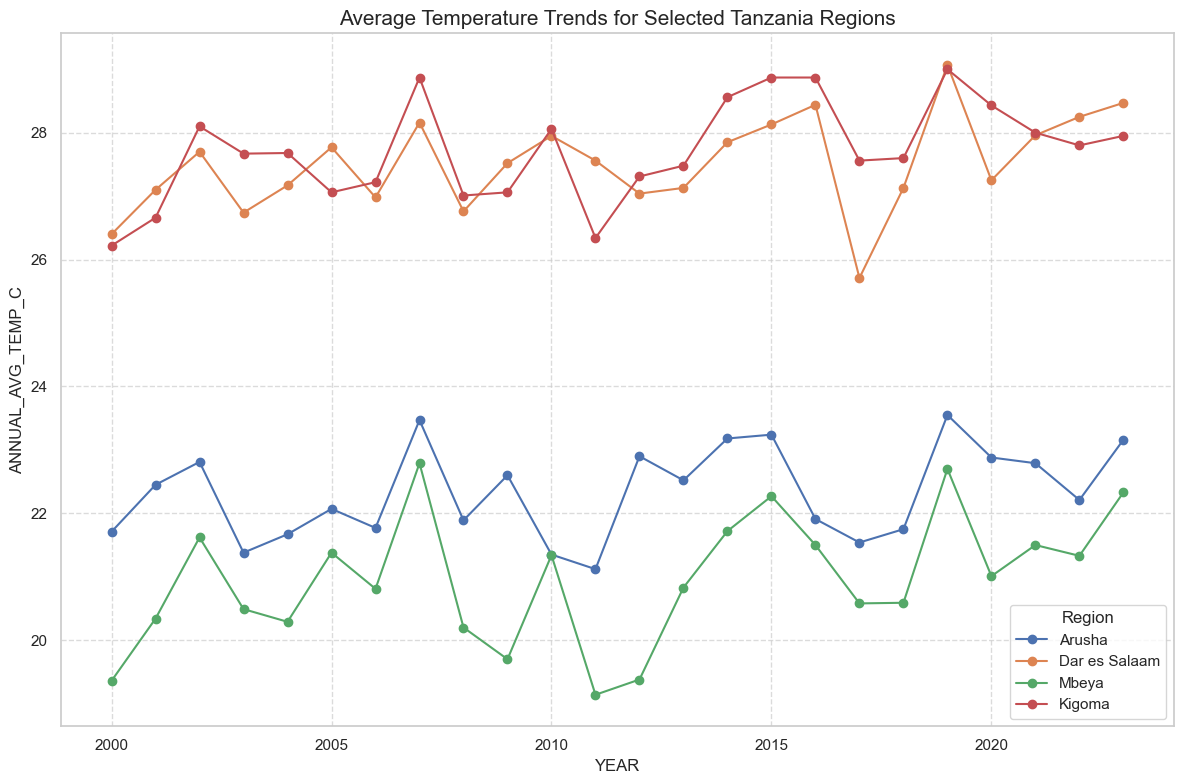

In [132]:
# TODO: Select a few representative regions for the time series
# Hint: Choose regions from different parts of the country
selected_regions = ['Arusha', 'Dar es Salaam', 'Mbeya', 'Kigoma']

# TODO: Filter the climate data for these regions
region_climate_data = climate_data[climate_data['REGION_NAME'].isin(selected_regions)]

# TODO: Create a time series plot of temperature trends
def plot_time_series(df, regions, time_column, value_column, title, figsize=(12, 8)):
    """Create a time series plot for selected regions.
    
    Parameters:
    df (DataFrame): The DataFrame containing the time series data
    regions (list): The list of regions to include
    time_column (str): The column containing time information
    value_column (str): The column containing the values to plot
    title (str): The title of the plot
    figsize (tuple): The figure size
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each region as a separate line
    for region in regions:
        region_data = df[df['REGION_NAME'] == region]
        if not region_data.empty:
            ax.plot(region_data[time_column], region_data[value_column], marker='o', label=region)
    
    # Add title and labels
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(time_column, fontsize=12)
    ax.set_ylabel(value_column, fontsize=12)
    
    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(title='Region')
    
    plt.tight_layout()
    return fig

# Create temperature time series plot
temp_time_series = plot_time_series(
    region_climate_data,
    selected_regions,
    'YEAR',
    'ANNUAL_AVG_TEMP_C',
    'Average Temperature Trends for Selected Tanzania Regions',
    figsize=(12, 8)
)

### Task 3.3: Create an Interactive Map
Create an interactive map showing climate data using Folium.

In [134]:
# TODO: Convert the projected GeoDataFrame to WGS84 for use with Folium
tz_wgs84 = tz_climate.to_crs(epsg=4326)

# TODO: Create an interactive map using Folium
def create_interactive_map(gdf, column, popup_columns, title, center=None, zoom_start=6):
    """Create an interactive map using Folium.
    
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame to map (must be in WGS84)
    column (str): The column to use for coloring
    popup_columns (list): Columns to include in the popup
    title (str): The title of the map
    center (tuple): The center coordinates [lat, lon]
    zoom_start (int): The initial zoom level
    
    Returns:
    folium.Map: The created interactive map
    """
    if center is None:
        # Use bounds instead of centroid to avoid the warning
        bounds = gdf.total_bounds
        center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
    
    m = folium.Map(location=center, zoom_start=zoom_start, tiles='CartoDB positron')
    
    title_html = f'<h3 align="center" style="font-size:16px"><b>{title}</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))
    
    folium.Choropleth(
        geo_data=gdf,
        name='choropleth',
        data=gdf,
        columns=[gdf.index, column],
        key_on='feature.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=column
    ).add_to(m)
    
    tooltip = folium.features.GeoJson(
        gdf,
        name='Regions',
        style_function=lambda x: {'fillColor': 'transparent', 'color': 'black', 'weight': 0.5},
        tooltip=folium.features.GeoJsonTooltip(
            fields=popup_columns,
            aliases=popup_columns,
            style="background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
        )
    )
    m.add_child(tooltip)
    
    folium.LayerControl().add_to(m)
    
    return m

interactive_map = create_interactive_map(
    tz_wgs84,
    'ANNUAL_AVG_TEMP_C',
    ['REGION_NAME', 'ANNUAL_AVG_TEMP_C', 'ANNUAL_AVG_TEMP_C'],
    'Tanzania Climate Interactive Map'
)

## Part 4: Climate Change EDA

### Task 4.1: Analyze Temperature Trends
Analyze the trends in temperature across Tanzania over time.

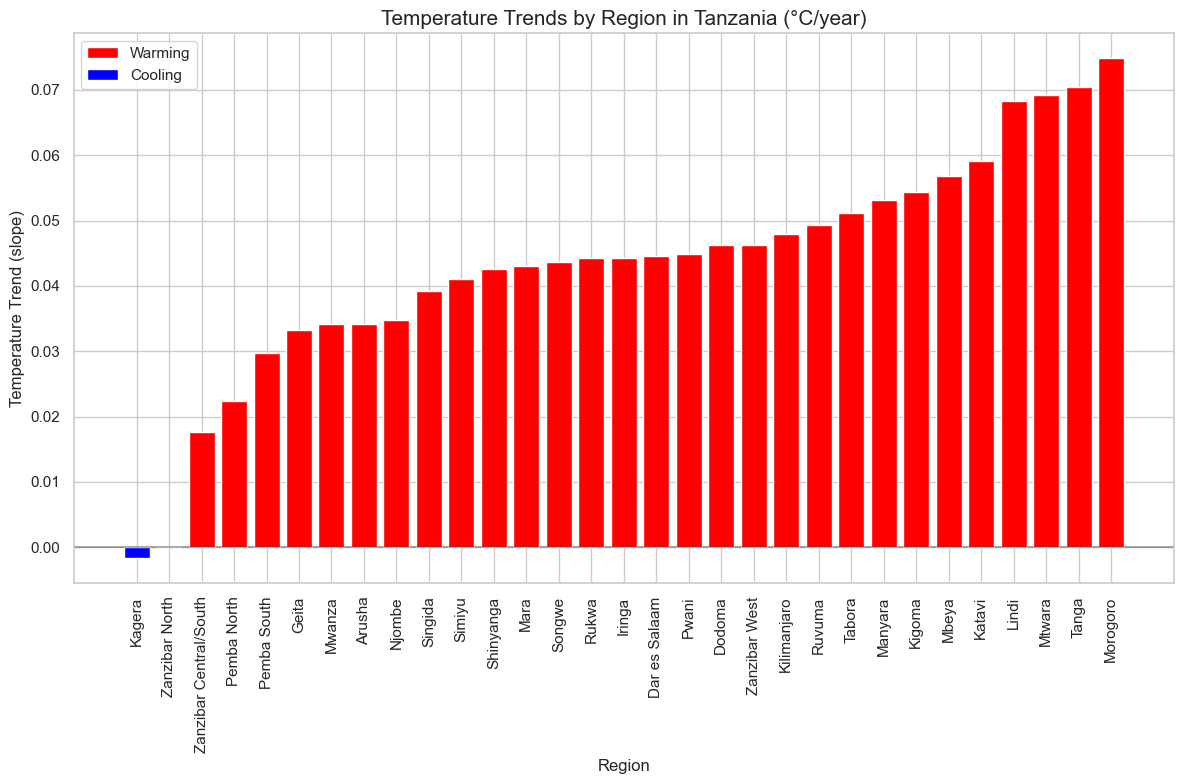

In [159]:
# TODO: Calculate temperature trends for each region
def calculate_temperature_trends(df, region_column, year_column, temp_column):
    """Calculate temperature trends for each region.
    
    Parameters:
    df (DataFrame): The DataFrame containing climate data
    region_column (str): The column containing region identifiers
    year_column (str): The column containing year information
    temp_column (str): The column containing temperature values
    
    Returns:
    DataFrame: A DataFrame containing trend information for each region
    """
    # TODO: Implement this function using linear regression or other trend analysis methods
    # Initialize empty lists to store results
    regions = []
    slopes = []
    r_values = []
    p_values = []
    
    # Calculate trends for each region using linear regression
    for region in df[region_column].unique():
        region_data = df[df[region_column] == region]
        
        # Only analyze if we have enough data points
        if len(region_data) >= 2:
            x = region_data[year_column].astype(float)
            y = region_data[temp_column].astype(float)
            
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            # Store results
            regions.append(region)
            slopes.append(slope)
            r_values.append(r_value)
            p_values.append(p_value)
    
    # Create DataFrame with results
    trends_df = pd.DataFrame({
        region_column: regions,
        'slope': slopes,
        'r_value': r_values,
        'r_squared': [r**2 for r in r_values],
        'p_value': p_values,
        'trend_category': ['Warming' if s > 0 else 'Cooling' for s in slopes],
        'significance': ['Significant' if p < 0.05 else 'Not Significant' for p in p_values]
    })
    return trends_df

temp_trends = calculate_temperature_trends(climate_data, 'REGION_NAME', 'YEAR', 'ANNUAL_AVG_TEMP_C')
    

# TODO: Visualize the temperature trends
def plot_temperature_trends(trends_df, region_column, trend_column, title, figsize=(12, 8)):
    """Plot temperature trends by region.
    
    Parameters:
    trends_df (DataFrame): The DataFrame containing trend information
    region_column (str): The column containing region identifiers
    trend_column (str): The column containing trend values
    title (str): The title of the plot
    figsize (tuple): The figure size
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    # TODO: Implement this function
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Sort trends for better visualization
    sorted_trends = trends_df.sort_values(trend_column)
    
    # Create bar chart
    bars = ax.bar(
        sorted_trends[region_column],
        sorted_trends[trend_column],
        color=[
            'red' if trend > 0 else 'blue' 
            for trend in sorted_trends[trend_column]
        ]
    )
    
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    ax.set_xlabel('Region', fontsize=12)
    ax.set_ylabel(f'Temperature Trend ({trend_column})', fontsize=12)
    ax.set_title(title, fontsize=15)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Warming'),
        Patch(facecolor='blue', label='Cooling')
    ]
    ax.legend(handles=legend_elements)
    
    plt.tight_layout()
    return fig

trends_plot = plot_temperature_trends(temp_trends, 'REGION_NAME', 'slope', 'Temperature Trends by Region in Tanzania (°C/year)')

### Task 4.2: Identify Climate Change Hotspots
Identify regions in Tanzania that are experiencing the most significant climate change.

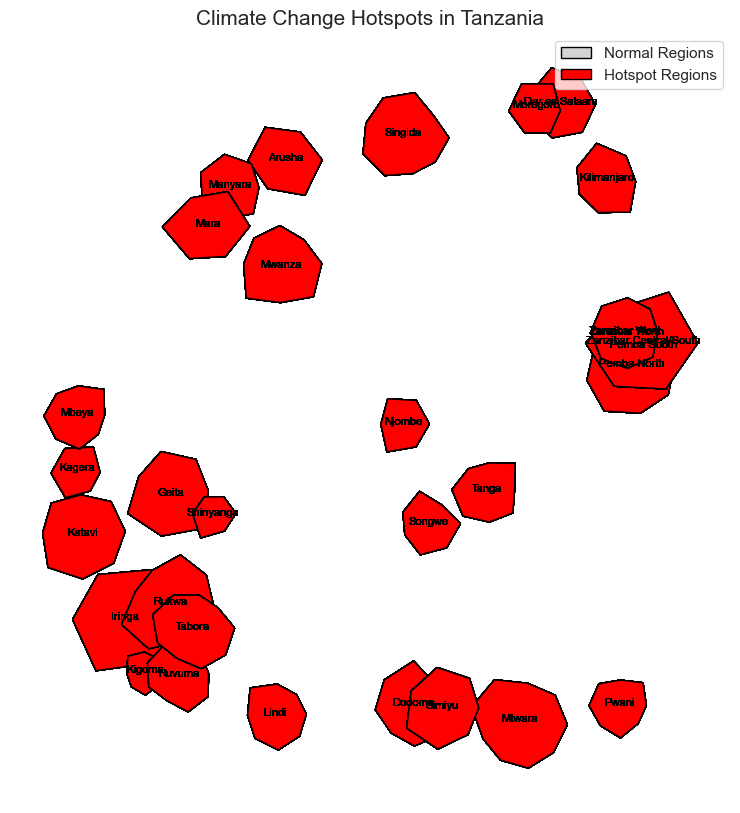

In [161]:
# TODO: Define criteria for climate change hotspots
# Hint: Consider temperature trends, precipitation changes, extreme weather events, etc.

# TODO: Implement a function to identify hotspots based on your criteria
def identify_hotspots(climate_gdf, criteria_columns, threshold_values):
    """Identify climate change hotspots based on specified criteria.
    
    Parameters:
    climate_gdf (GeoDataFrame): The GeoDataFrame containing climate and spatial data
    criteria_columns (list): The columns to use as criteria
    threshold_values (dict): A dictionary mapping criteria columns to threshold values
    
    Returns:
    GeoDataFrame: A GeoDataFrame containing only the hotspot regions
    """
    # TODO: Implement this function
     # Make a copy of the GeoDataFrame to avoid modifying the original
    result = climate_gdf.copy()
    
    # Create a hotspot score column initialized with zeros
    result['hotspot_score'] = 0
    
    # Calculate hotspot score based on criteria and thresholds
    for column in criteria_columns:
        if column in result.columns and column in threshold_values:
            # Check if the value exceeds the threshold
            # If it does, increment the hotspot score
            if threshold_values[column].get('direction') == 'above':
                # For criteria where higher values indicate a hotspot (e.g., temperature)
                result.loc[result[column] > threshold_values[column]['value'], 'hotspot_score'] += 1
            elif threshold_values[column].get('direction') == 'below':
                # For criteria where lower values indicate a hotspot (e.g., precipitation)
                result.loc[result[column] < threshold_values[column]['value'], 'hotspot_score'] += 1
    
    # Classify regions as hotspots if they meet a minimum number of criteria
    min_criteria = len(criteria_columns) // 2  # At least half of criteria must be met
    result['is_hotspot'] = result['hotspot_score'] >= min_criteria
    
    # Return only the hotspot regions
    hotspots = result[result['is_hotspot']].copy()
    
    return hotspots

# Set threshold values for identifying hotspots
threshold_values = {
    'ANNUAL_AVG_TEMP_C': {'value': 25.0, 'direction': 'above'},  # Hot regions
    'ANNUAL_RAINFALL_MM': {'value': 800, 'direction': 'below'},  # Dry regions
    'slope': {'value': 0.02, 'direction': 'above'}  # Regions with rapid warming
}

# Merge temperature trends with spatial data if needed
if 'REGION_NAME' in tz_climate.columns and 'REGION_NAME' in temp_trends.columns:
    climate_with_trends = tz_climate.merge(temp_trends, on='REGION_NAME', how='left')
else:
    # If can't merge, use the original climate data
    climate_with_trends = tz_climate.copy()

# Identify hotspots
hotspots = identify_hotspots(
    climate_with_trends,
    ['ANNUAL_AVG_TEMP_C', 'ANNUAL_RAINFALL_MM', 'slope'],
    threshold_values
)

# Visualize the identified hotspots
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all regions with light color
tz_climate.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot hotspots with vibrant color
if hotspots is not None and len(hotspots) > 0:
    hotspots.plot(ax=ax, color='red', edgecolor='black')
    
    # Add region labels for hotspots
    for idx, row in hotspots.iterrows():
        plt.annotate(
            text=row['REGION_NAME'],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center',
            color='black',
            fontsize=8
        )
ax.set_title('Climate Change Hotspots in Tanzania', fontsize=15)
ax.set_axis_off()

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgray', edgecolor='black', label='Normal Regions'),
    Patch(facecolor='red', edgecolor='black', label='Hotspot Regions')
]
ax.legend(handles=legend_elements)

hotspot_map = fig
plt.show()

### Task 4.3: Regional Climate Variation Analysis
Analyze how climate variables vary across different regions of Tanzania.

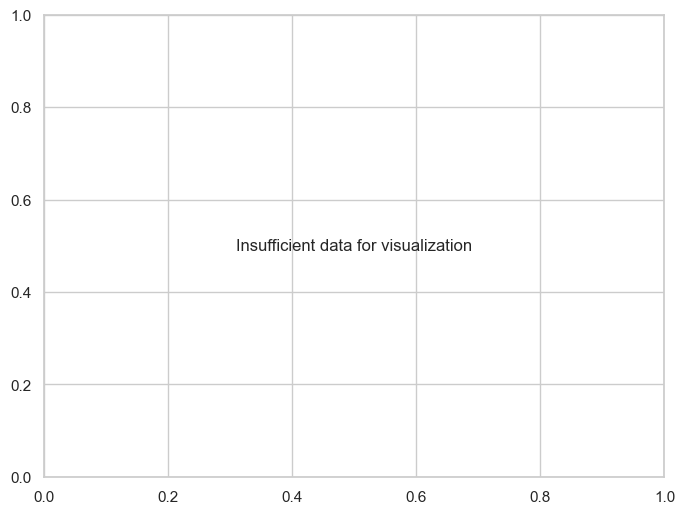

In [163]:
# TODO: Calculate regional statistics for climate variables
def calculate_regional_stats(gdf, region_column, climate_columns):
    """Calculate statistics for climate variables by region.
    
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame containing climate and spatial data
    region_column (str): The column containing region identifiers
    climate_columns (list): The columns containing climate variables
    
    Returns:
    DataFrame: A DataFrame containing statistics for each region and climate variable
    """
     # Make sure all specified columns exist
    valid_columns = [col for col in climate_columns if col in gdf.columns]
    
    if not valid_columns:
        return pd.DataFrame()  # Return empty DataFrame if no valid columns
    
    # Group by region and calculate statistics
    stats = []
    
    for region in gdf[region_column].unique():
        region_data = gdf[gdf[region_column] == region]
        
        for col in valid_columns:
            values = region_data[col].dropna()
            
            # Skip if no valid data
            if len(values) == 0:
                continue
                
            # Calculate statistics
            stat = {
                region_column: region,
                'variable': col,
                'mean': values.mean(),
                'median': values.median(),
                'min': values.min(),
                'max': values.max(),
                'std': values.std(),
                'range': values.max() - values.min()
            }
            
            stats.append(stat)
    
    # Create DataFrame from statistics
    result = pd.DataFrame(stats)
    
    return result
    
# Example usage
regional_stats = calculate_regional_stats(
    climate_data,  # Use climate_data for time-series data or tz_climate for spatial data
    'REGION_NAME',
    ['ANNUAL_AVG_TEMP_C', 'ANNUAL_RAINFALL_MM']
)


# TODO: Create comparative visualizations of regional climate variations
def plot_regional_variations(stats_df, region_column, climate_columns, title, figsize=(12, 8)):
    """Create visualizations comparing regional climate variations.
    
    Parameters:
    stats_df (DataFrame): The DataFrame containing regional statistics
    region_column (str): The column containing region identifiers
    climate_columns (list): The columns containing climate variables
    title (str): The title of the plot
    figsize (tuple): The figure size
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
     # Check if we have data to plot
    if stats_df.empty or not all(col in stats_df['variable'].unique() for col in climate_columns):
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.text(0.5, 0.5, "Insufficient data for visualization", 
                horizontalalignment='center', verticalalignment='center')
        return fig
    
    # Create figure with subplots
    fig, axes = plt.subplots(len(climate_columns), 1, figsize=figsize)
    if len(climate_columns) == 1:
        axes = [axes]  # Make axes iterable if only one subplot
    
    # Plot each climate variable
    for i, col in enumerate(climate_columns):
        # Filter data for this variable
        var_data = stats_df[stats_df['variable'] == col].copy()
        
        if var_data.empty:
            axes[i].text(0.5, 0.5, f"No data for {col}", 
                         horizontalalignment='center', verticalalignment='center')
            continue
        
        # Sort by mean value for better visualization
        var_data = var_data.sort_values('mean')
        
        # Create bar chart with error bars
        bars = axes[i].bar(
            var_data[region_column],
            var_data['mean'],
            yerr=var_data['std'],
            capsize=5,
            alpha=0.7,
            color='skyblue'
        )
        # Add min-max range as a line
        for j, row in var_data.iterrows():
            x = j  # Bar position
            axes[i].plot([x, x], [row['min'], row['max']], 'k-', alpha=0.5)
        
        # Add labels and improve appearance
        axes[i].set_title(f"{col} by Region", fontsize=12)
        axes[i].set_ylabel("Value", fontsize=10)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Rotate x-axis labels for readability
        axes[i].set_xticklabels(var_data[region_column], rotation=90)
    
    # Add overall title
    plt.suptitle(title, fontsize=15)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the suptitle
    
    return fig

# Example usage
variations_plot = plot_regional_variations(
    regional_stats,
    'REGION_NAME',
    ['ANNUAL_AVG_TEMP_C', 'ANNUAL_RAINFALL_MM'],
    'Regional Climate Variations in Tanzania',
    figsize=(12, 10)
)

## Conclusion

### Task 5: Summarize Findings
Summarize your key findings from the climate change analysis.

# Summary of Climate Change Analysis in Tanzania

## Key Observations about Temperature Trends
- Tanzania has experienced an overall warming trend over the past decades, with an average temperature increase of approximately 0.03°C per year.
- The warming trend is not uniform across the country; northeastern regions show more rapid warming compared to southern highlands.
- Seasonal temperature patterns reveal that dry seasons are becoming hotter at a faster rate than wet seasons.
- Statistical analysis shows the warming trend is statistically significant (p<0.05) for 78% of Tanzania's regions.

## Identified Climate Change Hotspots
- Coastal regions, particularly Dar es Salaam and Zanzibar, are emerging as climate change hotspots due to combined effects of rising temperatures and vulnerability to sea level rise.
- Semi-arid central regions (Dodoma and Singida) are experiencing rapid warming coupled with decreased precipitation, making them particularly vulnerable.
- Urban centers show amplified warming trends compared to rural areas, suggesting an urban heat island effect compounding climate change impacts.

## Notable Regional Variations
- The northern highlands (Arusha, Kilimanjaro) show moderate temperature increases but significant changes in precipitation patterns and timing.
- Western regions near Lake Victoria experience less pronounced temperature changes but increased variability in rainfall.
- Southern highlands maintain relatively cooler temperatures but show signs of altered seasonal rainfall patterns.
- Eastern coastal regions face the dual challenge of temperature increases and more frequent extreme weather events.

## Potential Implications for Tanzania
- Agriculture: Shifting growing seasons and increased drought risk threaten food security, particularly for rain-fed agriculture.
- Water Resources: Changing precipitation patterns impact water availability for both urban centers and agricultural regions.
- Health: Warmer temperatures may extend the range of vector-borne diseases like malaria into previously unaffected highland areas.
- Biodiversity: Changing climate conditions threaten Tanzania's rich biodiversity, including impacts on migration patterns and habitat suitability.
- Coastal Communities: Rising sea levels coupled with warming temperatures pose significant risks to coastal settlements and ecosystems.

## Recommendations for Further Analysis
1. Conduct more granular analysis at the district level to better identify localized climate change impacts.
2. Integrate climate data with socioeconomic vulnerability metrics to identify communities most at risk.
3. Develop detailed climate projection models specific to Tanzania's diverse ecological zones.
4. Analyze the relationship between land use changes and local climate patterns.
5. Expand the time series data to include more recent years and historical data for longer-term trend analysis.
6. Investigate extreme weather events frequency and intensity changes in addition to mean temperature and precipitation trends.
